## TODOs:

### Drop useless features
  * venue
  * wind_speed
  * game_page_url
  * start_time

### Use Quartiles to label different attendance levels
  * 0-25%: Low
  * 25-50%: Medium
  * 50-75%: High
  * 75-100%: Very High
### Use common dimensionality reduction techniques:
  * PCA
  * MDS
  * LLE
    * use 20, 40 neighbors
    * perform PCA transformation first and use first 20 components
  * Kernel PCA
    * RBF
    * Cosine
  * t-SNE
    * Euclidian
    * Cosine
    * Jaccard

In [1]:
import pandas as pd

trainset = pd.read_csv("processed_training_final.csv")
testset = pd.read_csv("processed_test_final.csv")

print(trainset.shape)
print(testset.shape)

(12270, 220)
(2445, 220)


In [2]:
trainset.head()

,attendance,is_federal_holiday,venue,on_grass,temperature,wind_speed,team1_name,team1_pre_win,team1_pre_loss,team1_pre_win_pct,...,season,home_team_avg_att_last_year,start_hour,start_hour_label_afternoon,start_hour_label_evening,start_hour_label_night,start_hour_label_noon,game_page_url,start_time,previous_5_to_10MA
0,35055,0,Wrigley Field,1,-2.786672,-0.093090,STL,-1.62645,-1.654514,0.0,...,2015,0.345307,19,0,1,0,0,https://www.baseball-reference.com/boxes/CHN/C...,2015-04-05 19:17:00,32742.135802
1,45030,0,Comerica Park,1,-2.031671,-0.489072,MIN,-1.62645,-1.654514,0.0,...,2015,0.766348,13,0,0,0,1,https://www.baseball-reference.com/boxes/DET/D...,2015-04-06 13:08:00,36014.925926
2,45909,0,Safeco Field,1,-1.842921,-1.281036,LAA,-1.62645,-1.654514,0.0,...,2015,-0.588237,13,0,0,0,1,https://www.baseball-reference.com/boxes/SEA/S...,2015-04-06 13:12:00,25485.604938
3,53518,0,Dodger Stadium,1,-0.804795,-1.281036,SDP,-1.62645,-1.654514,0.0,...,2015,2.140393,13,0,0,0,1,https://www.baseball-reference.com/boxes/LAN/L...,2015-04-06 13:12:00,46695.518519
4,48469,0,Yankee Stadium III,1,-1.842921,-0.489072,TOR,-1.62645,-1.654514,0.0,...,2015,1.603257,13,0,0,0,1,https://www.baseball-reference.com/boxes/NYA/N...,2015-04-06 13:13:00,42520.300000


In [3]:
# make sure the column order is the same in both datasets
train_cols = trainset.columns.tolist()
testset = testset[train_cols].copy()

In [4]:
# create a list to store the level of attendance for each game, the level is divided by quartile
# 0: 0-25%
# 1: 25-50%
# 2: 50-75%
# 3: 75-100%
train_attendance_level = []
attendance_quartiles = trainset['attendance'].quantile([0, 0.25, 0.5, 0.75, 1]).tolist()

def get_attendance_level(attendance):
    if attendance <= attendance_quartiles[1]:
        return 0
    elif attendance <= attendance_quartiles[2]:
        return 1
    elif attendance <= attendance_quartiles[3]:
        return 2
    else:
        return 3

for attendance in trainset['attendance']:
    train_attendance_level.append(get_attendance_level(attendance))

print(f"the level distribution of attendance is \n{pd.Series(train_attendance_level).value_counts()}")

the level distribution of attendance is 
0    3069
3    3068
1    3067
2    3066
dtype: int64


In [5]:
# try to use PCA to reduce only player one-hot features to 2 dimensions and visualize the result with attendance level to see if there is any pattern

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib


Duplicate key in file PosixPath('/opt/homebrew/lib/python3.10/site-packages/matplotlib/mpl-data/matplotlibrc'), line 263 ('font.family:  sans-serif')


In [6]:
player_one_hot_features = trainset.iloc[:, 16:184]
category_names = {0: "0-25%", 1: "25-50%", 2: "50-75%", 3: "75-100%"}
att_level = pd.Series(train_attendance_level)
att_level = att_level.map(category_names)
category_names = list(category_names.values())

From above four pictures, we don't see any obvious clusters. Let's try different dimensionality reduction techniques.

PCA

In [7]:
# standardize the data
scaler = StandardScaler()
d1 = scaler.fit_transform(player_one_hot_features)

# use PCA to reduce the dimension to 2
pca = PCA(n_components=8)
d1 = pca.fit_transform(d1)

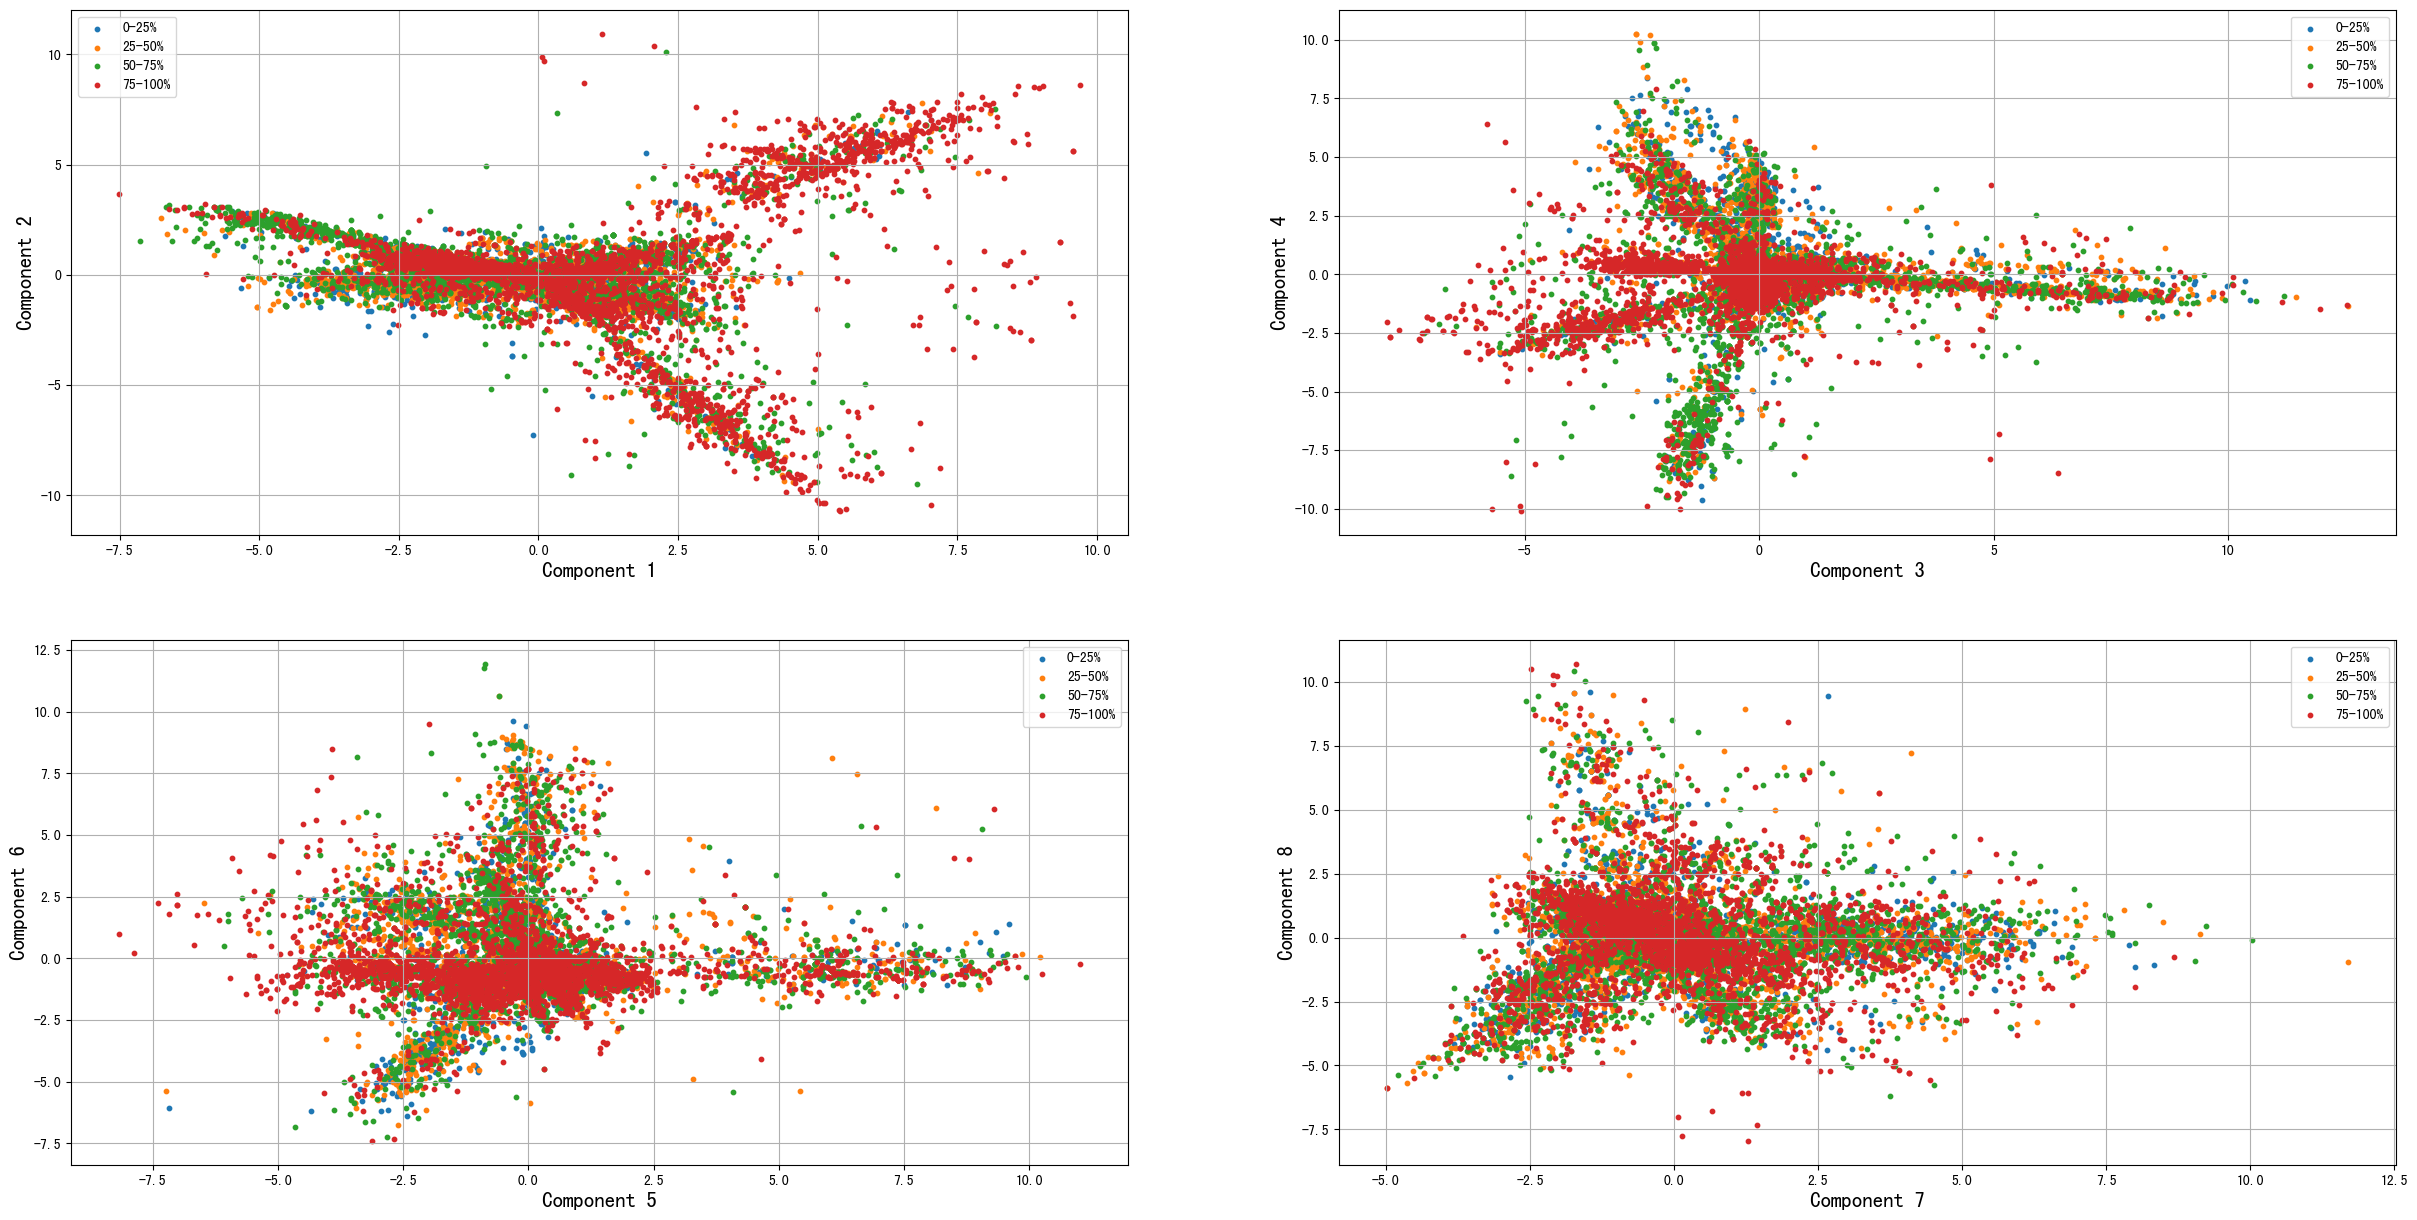

In [8]:

fig = plt.figure(figsize = (30,15))

for i, (c1, c2) in enumerate([(0,1), (2,3), (4,5), (6,7)], start=1):
   ax = fig.add_subplot(2,2,i) 
   ax.set_xlabel(f'Component {c1+1}', fontsize = 15)
   ax.set_ylabel(f'Component {c2+1}', fontsize = 15)
   # ax.set_title('2 component PCA', fontsize = 20)
   for category_name in category_names:
      indicesToKeep = att_level == category_name
      ax.scatter(d1[indicesToKeep, c1]
                  , d1[indicesToKeep, c2]
                  , s = 10)
   ax.legend(category_names)
   ax.grid()

MDS

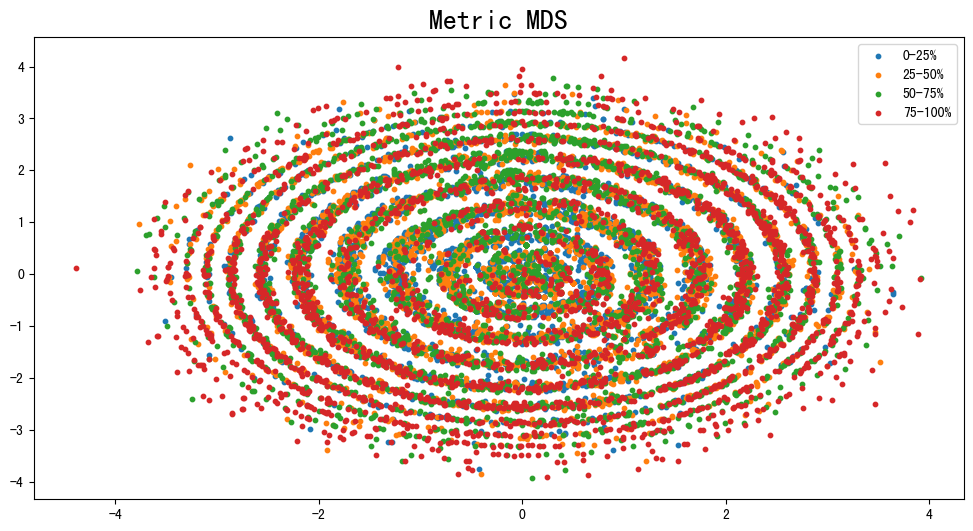

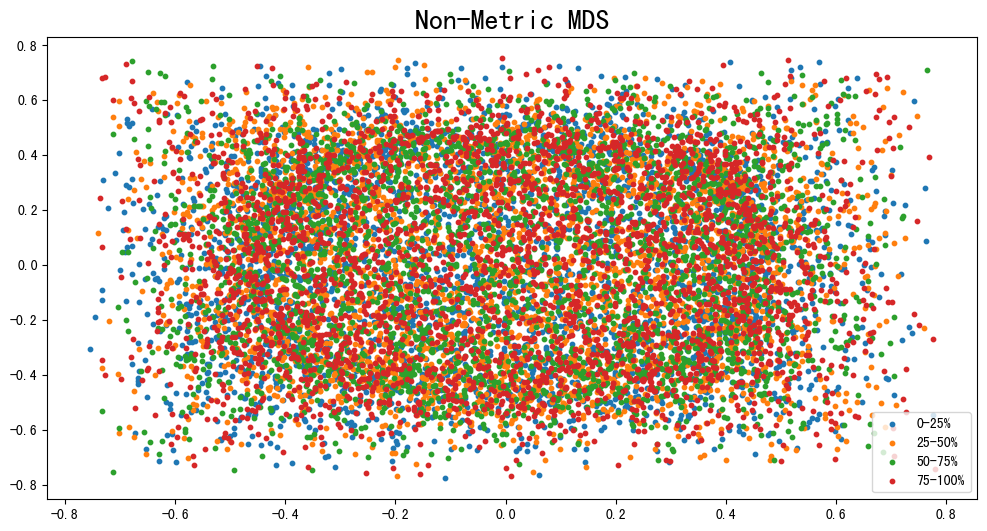

In [35]:
# use MDS to reduce dimensionality and plot scatter plot
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

mds = MDS(n_components=2, metric=True)
mds = mds.fit_transform(player_one_hot_features)

plt.figure(figsize = (12,6))
plt.title('Metric MDS', fontsize = 20)
for category_name in category_names:
   indicesToKeep = att_level == category_name
   plt.scatter(mds[indicesToKeep, 0]
               , mds[indicesToKeep, 1]
               , s = 10)
plt.legend(category_names )
plt.show()

mds = MDS(n_components=2, metric=False)
mds = mds.fit_transform(player_one_hot_features)

plt.figure(figsize = (12,6))
plt.title('Non-Metric MDS', fontsize = 20)
for category_name in category_names:
   indicesToKeep = att_level == category_name
   plt.scatter(mds[indicesToKeep, 0]
               , mds[indicesToKeep, 1]
               , s = 10)
plt.legend(category_names)
plt.show()

LLE

In [13]:
# using LLE with 20 neighbors to reduce dimensionality
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.decomposition import PCA

d1 = LocallyLinearEmbedding(n_components=2, n_neighbors=20)
d1 = d1.fit_transform(player_one_hot_features)

d2 = LocallyLinearEmbedding(n_components=2, n_neighbors=40)
d2 = d2.fit_transform(player_one_hot_features)

pca = PCA(n_components=100)
pcs = pca.fit_transform(player_one_hot_features)
d3 = LocallyLinearEmbedding(n_components=2, n_neighbors=40)
d3 = d3.fit_transform(pcs)

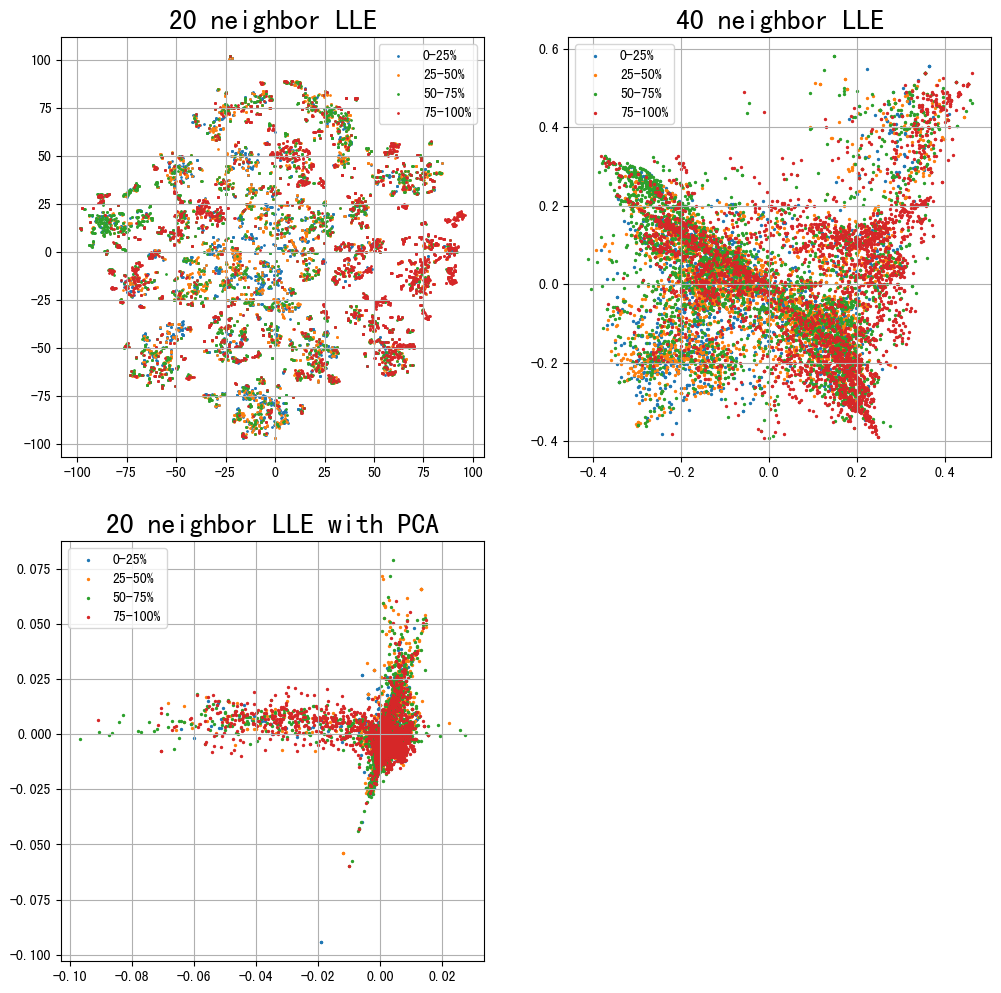

In [54]:
fig = plt.figure(figsize = (12,12))

ax = fig.add_subplot(2,2,1) 
ax.set_title('20 neighbor LLE', fontsize = 20)
for category_name in category_names:
   indicesToKeep = att_level == category_name
   ax.scatter(d1[indicesToKeep, 0]
               , d1[indicesToKeep, 1]
               , s = 1)
ax.legend(category_names)
ax.grid()

ax = fig.add_subplot(2,2,2) 
ax.set_title('40 neighbor LLE', fontsize = 20)
for category_name in category_names:
   indicesToKeep = att_level == category_name
   ax.scatter(d2[indicesToKeep, 0]
               , d2[indicesToKeep, 1]
               , s = 2)
ax.legend(category_names)
ax.grid()

ax = fig.add_subplot(2,2,3) 
ax.set_title('20 neighbor LLE with PCA', fontsize = 20)
for category_name in category_names:
   indicesToKeep = att_level == category_name
   ax.scatter(d3[indicesToKeep, 0]
               , d3[indicesToKeep, 1]
               , s = 2)
ax.legend(category_names)
ax.grid()

KernalPCA

In [39]:
from sklearn.decomposition import KernelPCA

kernel1 = KernelPCA(n_components=2, kernel='rbf')
d1 = kernel1.fit_transform(player_one_hot_features)

kernel2 = KernelPCA(n_components=2, kernel='cosine')
d2 = kernel2.fit_transform(player_one_hot_features)



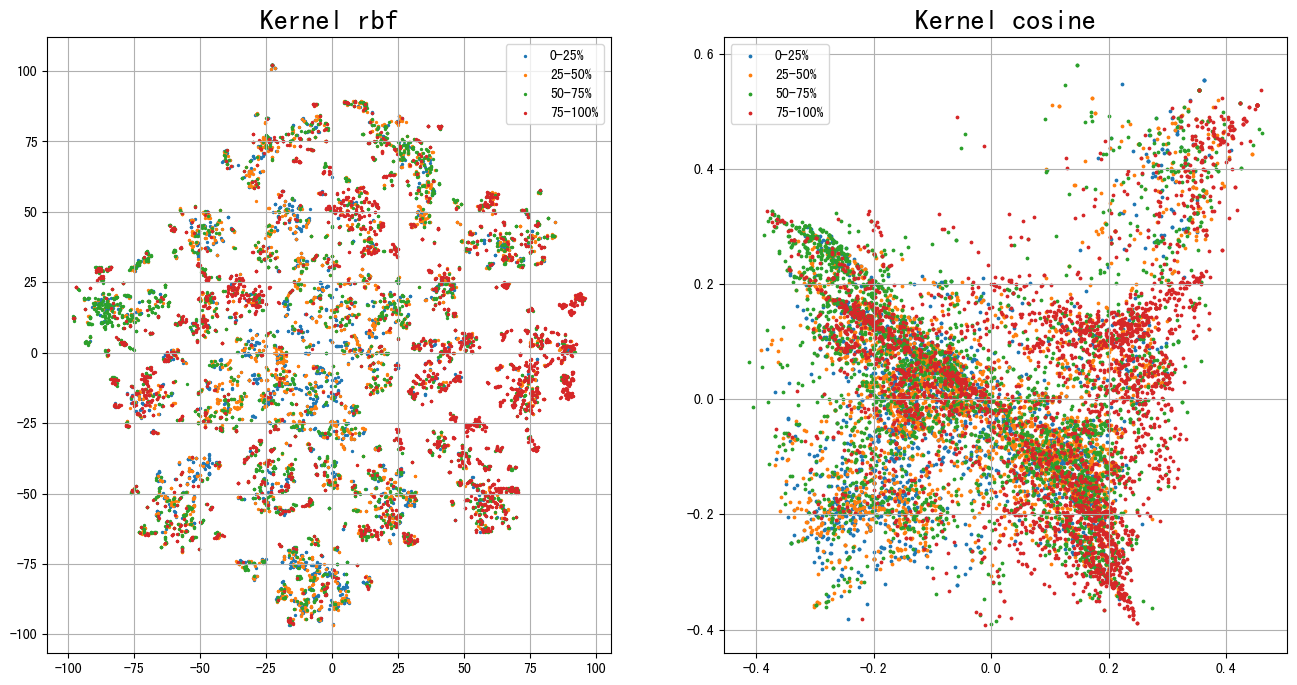

In [51]:
fig = plt.figure(figsize = (16, 8))

ax = fig.add_subplot(1,2,1) 
ax.set_title('Kernel rbf', fontsize = 20)
for category_name in category_names:
   indicesToKeep = att_level == category_name
   ax.scatter(d1[indicesToKeep, 0]
               , d1[indicesToKeep, 1]
               , s = 2)
ax.legend(category_names)
ax.grid()

ax = fig.add_subplot(1,2,2) 
ax.set_title('Kernel cosine', fontsize = 20)
for category_name in category_names:
   indicesToKeep = att_level == category_name
   ax.scatter(d2[indicesToKeep, 0]
               , d2[indicesToKeep, 1]
               , s = 3)
ax.legend(category_names)
ax.grid()

TSNE

In [20]:
from sklearn.manifold import TSNE

ds = []

tsne = TSNE(n_components=2, metric='euclidean', random_state=42)
d1 = tsne.fit_transform(player_one_hot_features)
ds.append(d1)

tsne = TSNE(n_components=2, metric='cosine', random_state=42)
d1 = tsne.fit_transform(player_one_hot_features)
ds.append(d1)

tsne = TSNE(n_components=2, metric='jaccard', random_state=42)
d1 = tsne.fit_transform(player_one_hot_features)
ds.append(d1)


c:\Users\user\Anaconda3\envs\python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\user\Anaconda3\envs\python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\user\Anaconda3\envs\python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\user\Anaconda3\envs\python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\user\Anaconda3\envs\python39\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting

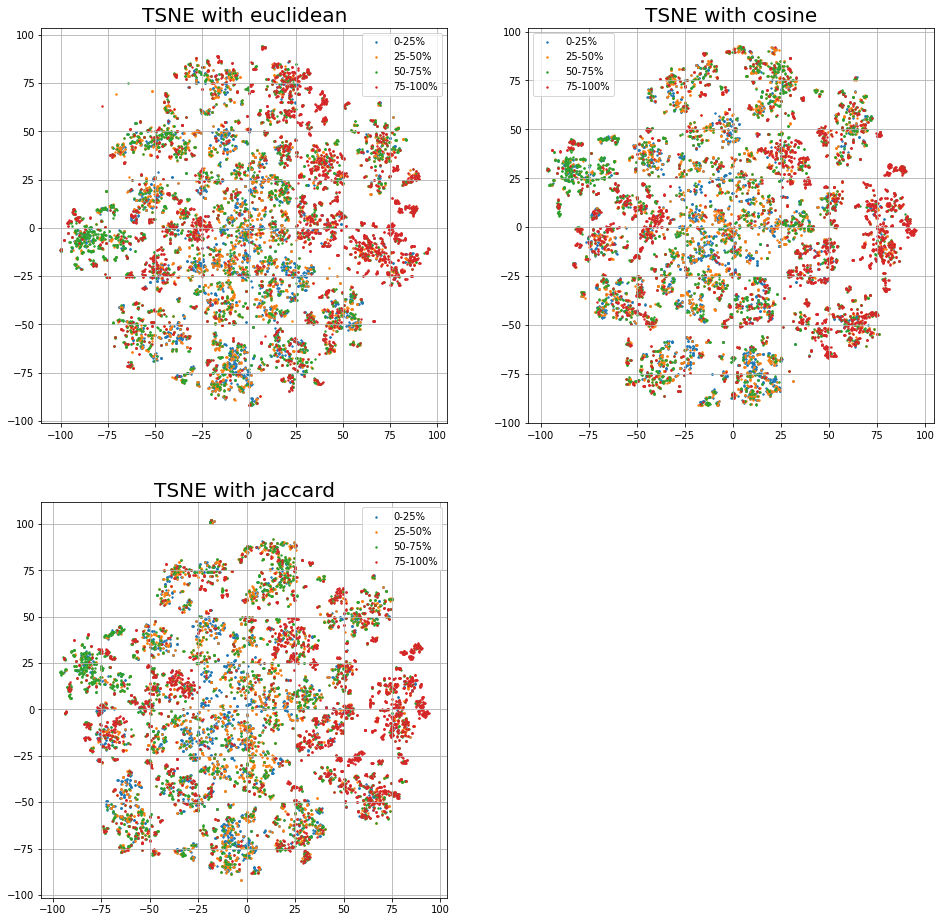

In [21]:
fig = plt.figure(figsize = (16, 16))

for i,( d, title) in enumerate(zip(ds, ['TSNE with euclidean','TSNE with cosine','TSNE with jaccard']), 1):
    ax = fig.add_subplot(2,2,i) 
    ax.set_title(title, fontsize = 20)
    for category_name in category_names:
        indicesToKeep = att_level == category_name
        ax.scatter(d[indicesToKeep, 0]
                    , d[indicesToKeep, 1]
                    , s = 2)
    ax.legend(category_names)
    ax.grid()

In [31]:
# fit t-SNE with jaccard distance and transform on test data
best_tsne = TSNE(n_components=2, metric='jaccard', random_state=42).fit(player_one_hot_features)
best_tsne_train = best_tsne.transform(player_one_hot_features)

test_player_one_hot_features = testset.iloc[:, 16:184]
tsne_test = best_tsne.fit_transform(test_player_one_hot_features)

c:\Users\user\Anaconda3\envs\python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\user\Anaconda3\envs\python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\user\Anaconda3\envs\python39\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(
c:\Users\user\Anaconda3\envs\python39\lib\site-packages\sklearn\metrics\pairwise.py:1875: DataConversionWarning: Data was converted t

In [34]:
# ds[2] is t-SNE with jaccard distance and performs the best. Let's merge it with the original data
tsne_jaccard_df_train = pd.DataFrame(ds[2], columns=['tsne1', 'tsne2'])
tsne_jaccard_df_test = pd.DataFrame(tsne_test, columns=['tsne1', 'tsne2'])
# drop player one hot features and add tsne features
trainset_drop = trainset.drop(trainset.iloc[:, 16:184], axis=1)
testset_drop = testset.drop(testset.iloc[:, 16:184], axis=1)
merged_trainset = pd.concat([trainset_drop, tsne_jaccard_df_train], axis=1)
merged_testset = pd.concat([testset_drop, tsne_jaccard_df_test], axis=1)

In [36]:
print(f"merged trainset shape: {merged_trainset.shape}")
print(f"merged testset shape: {merged_testset.shape}")

merged trainset shape: (12270, 54)
merged testset shape: (2445, 54)


In [37]:
merged_trainset.head()

,attendance,is_federal_holiday,venue,on_grass,temperature,wind_speed,team1_name,team1_pre_win,team1_pre_loss,team1_pre_win_pct,...,start_hour,start_hour_label_afternoon,start_hour_label_evening,start_hour_label_night,start_hour_label_noon,game_page_url,start_time,previous_5_to_10MA,tsne1,tsne2
0,35055,0,Wrigley Field,1,-2.786672,-0.093090,STL,-1.62645,-1.654514,0.0,...,19,0,1,0,0,https://www.baseball-reference.com/boxes/CHN/C...,2015-04-05 19:17:00,32742.135802,47.499054,-25.543898
1,45030,0,Comerica Park,1,-2.031671,-0.489072,MIN,-1.62645,-1.654514,0.0,...,13,0,0,0,1,https://www.baseball-reference.com/boxes/DET/D...,2015-04-06 13:08:00,36014.925926,6.712464,-43.446476
2,45909,0,Safeco Field,1,-1.842921,-1.281036,LAA,-1.62645,-1.654514,0.0,...,13,0,0,0,1,https://www.baseball-reference.com/boxes/SEA/S...,2015-04-06 13:12:00,25485.604938,-40.853245,-33.023666
3,53518,0,Dodger Stadium,1,-0.804795,-1.281036,SDP,-1.62645,-1.654514,0.0,...,13,0,0,0,1,https://www.baseball-reference.com/boxes/LAN/L...,2015-04-06 13:12:00,46695.518519,75.554482,-13.600916
4,48469,0,Yankee Stadium III,1,-1.842921,-0.489072,TOR,-1.62645,-1.654514,0.0,...,13,0,0,0,1,https://www.baseball-reference.com/boxes/NYA/N...,2015-04-06 13:13:00,42520.300000,-67.364456,-5.908486


In [7]:
# using LLE with 20 neighbors to reduce dimensionality
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.decomposition import PCA

best_lle = LocallyLinearEmbedding(n_components=2, n_neighbors=20).fit(player_one_hot_features)
train_lle = best_lle.transform(player_one_hot_features)

test_player_one_hot_features = testset.iloc[:, 16:184]
test_lee = best_lle.transform(test_player_one_hot_features)

print(f"train lle shape: {train_lle.shape}")
print(f"test lle shape: {test_lee.shape}")

train lle shape: (12270, 2)
test lle shape: (2445, 2)


In [8]:
# merge LLE with original data
lle_df_train = pd.DataFrame(train_lle, columns=['lle1', 'lle2'])
lle_df_test = pd.DataFrame(test_lee, columns=['lle1', 'lle2'])
# drop player one hot features and add lle features
trainset_drop = trainset.drop(trainset.iloc[:, 16:184], axis=1)
testset_drop = testset.drop(testset.iloc[:, 16:184], axis=1)
merged_trainset = pd.concat([trainset_drop, lle_df_train], axis=1)
merged_testset = pd.concat([testset_drop, lle_df_test], axis=1)

print(f"merged trainset shape: {merged_trainset.shape}")
print(f"merged testset shape: {merged_testset.shape}")

merged trainset shape: (12270, 54)
merged testset shape: (2445, 54)


In [9]:
# save the merged trainset and testset
merged_trainset.to_csv('trainset_w_lle.csv', index=False)
merged_testset.to_csv('testset_w_lle.csv', index=False)